In [43]:
# The Usuals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
!pip install category-encoders

In [3]:
import category_encoders as ce

## Import Data

In [4]:
!chmod 777 ../Data/train.csv
!chmod 777 ../Data/test.csv

# get train and test sets
trainval = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [5]:
trainval_molecules = trainval['molecule_name'].unique()
test_molecules = test['molecule_name'].unique()

In [6]:
train_molecules, val_molecules = train_test_split(
    trainval_molecules, random_state=32)

In [7]:
train = trainval[trainval['molecule_name'].isin(train_molecules)]
val = trainval[trainval['molecule_name'].isin(val_molecules)]

In [8]:
train.shape, val.shape, test.shape

((3492283, 6), (1165864, 6), (2505542, 5))

## Model

In [9]:
# features & target
features = ['type']
target = 'scalar_coupling_constant'

In [10]:
# Train
X_train = train[features]
y_train = train[target]

# Val
X_val = val[features]
y_val = val[target]

## Encode

In [15]:
encoder = ce.OrdinalEncoder()

In [20]:
X_train = pd.DataFrame(encoder.fit_transform(X_train.values))

In [21]:
X_val = pd.DataFrame(encoder.transform(X_val.values))

In [22]:
# Instantiate rf
rf = RandomForestRegressor(n_estimators=100, random_state=32)

# fit
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=32, verbose=0, warm_start=False)

In [23]:
# make predictions
y_pred = rf.predict(X_val)

In [28]:
# metric
groups = X_train[0]

def group_mean_log_mae(y_true, y_pred, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [29]:
group_mean_log_mae(y_val, y_pred)

1.4529616324460817

## Model with XGBoost

In [33]:
from xgboost import XGBRegressor

# instantiate model
model = XGBRegressor(n_estimators=100, max_depth=10, random_state=32)

# fit model
model.fit(X_train, y_train)

[16:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=32,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [34]:
# make predictions
y_pred = model.predict(X_val)

In [35]:
group_mean_log_mae(y_val, y_pred)

1.4529320990612868

## XGBoost Early Stopping

In [38]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [41]:
model = XGBRegressor(n_estimators=1000, n_jobs=-1)

model.fit(X_train, y_train, early_stopping_rounds=10,
          eval_metric='rmse', eval_set=eval_set)

[16:55:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:34.4278	validation_1-rmse:34.5378
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:31.167	validation_1-rmse:31.2892
[2]	validation_0-rmse:28.2867	validation_1-rmse:28.3766
[3]	validation_0-rmse:25.7155	validation_1-rmse:25.7867
[4]	validation_0-rmse:23.3965	validation_1-rmse:23.4832
[5]	validation_0-rmse:21.3452	validation_1-rmse:21.4321
[6]	validation_0-rmse:19.5448	validation_1-rmse:19.6098
[7]	validation_0-rmse:17.966	validation_1-rmse:18.0164
[8]	validation_0-rmse:16.5534	validation_1-rmse:16.6161
[9]	validation_0-rmse:15.3198	validation_1-rmse:15.3895
[10]	validation_0-rmse:14.2533	validation_1-rmse:14.3143
[11]	validation_0-rmse:13.3274	validation_1-rmse:13.3816
[12]	validation_0-rmse:12.5266	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

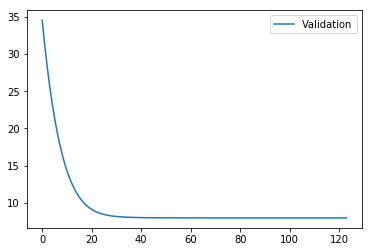

In [46]:
results = model.evals_result()
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();